## Assist customer to discover the best restaurant by using sentiment analysis and recommender algorithm
Whenever I need recommendations for restaurants, I YELP. However, it takes a lot time to read all the reviews if you also find the star ratings lack detail information. More importantly, I would love to get recommendations based on my like/dislike reviews on the restaurants along with other users’ like/dislike reviews. Therefore, I propose to investigate Yelp’s dataset, which included the information of business details, user, customer reviews and photos. By using sentiment analysis and recommender algorithm, I hope to assist customers discover the best restaurants. Yelp’s dataset is avaliable from Yelp’s 2019 dataset challenge (https://www.yelp.com/dataset).

## Outline

1. **Import and explore Data** <br>
    1a. read in yelp business data <br>
    1b. read in yelp user review data <br>
    1c. Filter the yelp business, only select Chinese Restaurant business <br>
    1d. Merge the chinese restaurant business dataframe with the customer review dataframe <br>

2. **Present customer review data using Word Clouds** <br>
    2a. Review text preprocessing, clean reviews <br>
    2b. Word Clouds for Chinese Restaurants <br>


3. **New features (positive review rate for restaurant) to help user choose restaurant using Sentiment Analysis** <br>
    3a. Clean Reviews and Review Sentiment Analysis <br>
    3b. Calculate the positive review ratio for Chinese restaurant <br>
    3c. Explore the relationship between restaurant "stars" rating and positive review ratio <br>

4. **Restaurant recommender system** <br>
    4a. Recommender algorithm <br>
    4b. Recommendation generation: obtain a restaurant list for a given user <br>



In [4]:
# import package·
import json
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import nltk
from textblob import TextBlob
from string import punctuation
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator, STOPWORDS
from PIL import Image
from os import path
import pylab as pl
import pandas as pd
from sklearn.metrics import mean_squared_error

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
pd.set_option('display.max_columns', 999)

## Part 1: Import and explore Data

### Part 1a: read in yelp business data

In [6]:
# read json to dictionary 
business = [json.loads(line) for line in open('yelp_dataset/business.json', 'r')]

#convert json dictionary to panda dataframe
businessDF = json_normalize(business)

In [7]:
businessDF.head(2)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours,attributes.GoodForKids,attributes.RestaurantsReservations,attributes.GoodForMeal,attributes.BusinessParking,attributes.Caters,attributes.NoiseLevel,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.RestaurantsPriceRange2,attributes.OutdoorSeating,attributes.BikeParking,attributes.Ambience,attributes.HasTV,attributes.WiFi,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsGoodForGroups,attributes.RestaurantsDelivery,hours.Monday,hours.Tuesday,hours.Wednesday,hours.Thursday,hours.Friday,hours.Saturday,hours.Sunday,attributes.BusinessAcceptsCreditCards,attributes,attributes.BusinessAcceptsBitcoin,attributes.ByAppointmentOnly,attributes.AcceptsInsurance,attributes.Music,attributes.GoodForDancing,attributes.CoatCheck,attributes.HappyHour,attributes.BestNights,attributes.WheelchairAccessible,attributes.DogsAllowed,attributes.BYOBCorkage,attributes.DriveThru,attributes.Smoking,attributes.AgesAllowed,attributes.HairSpecializesIn,attributes.Corkage,attributes.BYOB,attributes.DietaryRestrictions,attributes.Open24Hours,attributes.RestaurantsCounterService
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,"Golf, Active Life",NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"Specialty Food, Restaurants, Dim Sum, Imported...",NaN,True,True,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': False, 'validated'...",True,u'loud',True,True,2,False,False,"{'romantic': False, 'intimate': False, 'classy...",False,u'no',u'full_bar',u'casual',True,False,9:0-0:0,9:0-0:0,9:0-0:0,9:0-0:0,9:0-1:0,9:0-1:0,9:0-0:0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
print(businessDF.shape)

(192609, 60)


In [9]:
# data exploration
# businessDF.columns
# businessDF.dtypes
# businessDF.isnull().sum()
# businessDF['categories'][:5]

Text(0, 0.5, 'Count')

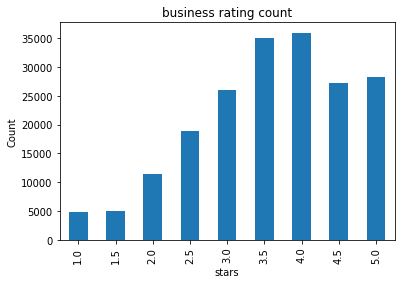

In [9]:
ratingCount = businessDF.groupby('stars').count()['city']
ratingCount.plot(kind = 'bar', title = 'business rating count')
plt.ylabel('Count')
plt.show()

### Part 1b: read in yelp user review data

In [23]:
review = [json.loads(line) for line in open('yelp_dataset/review.json', 'r')] # takes 2 mins

#convert json dictionary to panda dataframe
reviewDF = json_normalize(review) #5:05pm

# It takes long time to read in the review json file and convert it to csv
reviewDF.to_csv('review.csv')

### Part 1c: Filter the yelp business, only select Chinese Restaurant business

In [30]:
"""by explore the columns in the businessDF dataframe, I selected nice restaurant related columns and use them to filter
 out the restaurant business. 
 these nine columns are: selected restaurant features; attributes.RestaurantsReservations; attributes.GoodForMeal;                  
attributes.Caters; attributes.RestaurantsTableService; attributes.RestaurantsTakeOut; attributes.RestaurantsPriceRange2;
attributes.RestaurantsAttire; attributes.RestaurantsGoodForGroups; attributes.RestaurantsDelivery """

# Select restaurant/food business
restaurant = businessDF[(~businessDF['attributes.GoodForMeal'].isnull()) | (~businessDF['attributes.RestaurantsReservations'].isnull()) | \
                        (~businessDF['attributes.Caters'].isnull()) | (~businessDF['attributes.RestaurantsTableService'].isnull()) | \
                        (~businessDF['attributes.RestaurantsTakeOut'].isnull()) | (~businessDF['attributes.RestaurantsPriceRange2'].isnull()) | \
                        (~businessDF['attributes.RestaurantsAttire'].isnull()) | (~businessDF['attributes.RestaurantsGoodForGroups'].isnull()) | \
                        (~businessDF['attributes.RestaurantsDelivery'].isnull())]

# select Chinese restaurant/food business
ChineseRes = restaurant[restaurant['categories'].str.contains('Chinese') | restaurant['categories'].str.contains('chinese')\
                             | restaurant['categories'].str.contains('China')] 


In [230]:
print(ChineseRes.shape)

(4304, 60)


### Part 1d: Merge the chinese restaurant business dataframe with the customer review dataframe 

In [29]:
review_chinese = pd.merge(ChineseRes['business_id'], reviewDF, how = 'left', left_on = 'business_id', right_on = 'business_id')
review_chinese.to_csv('review_chinese.csv')

In [160]:
review_chinese = pd.read_csv('review_chinese.csv')

In [161]:
print(review_chinese.shape)

(261214, 10)


In [162]:
review_chinese.head(2)

,Unnamed: 0,business_id,review_id,user_id,stars,useful,funny,cool,text,date
0,0,QXAEGFB4oINsVuTFxEYKFQ,6W0MQHmasK0IsaoDo4bmkw,2K62MJ4CJ19L8Tp5pRfjfQ,3.0,3,2,0,My girlfriend and I went for dinner at Emerald...,2017-01-27 21:54:30
1,1,QXAEGFB4oINsVuTFxEYKFQ,BeeBfUxvzD4qNX4HxrgA5g,A0kENtCCoVT3m7T35zb2Vg,3.0,0,0,0,We've always been there on a Sunday so we were...,2013-06-24 23:11:30


## Part 2: Present customer review data using Word Clouds

### Part 2a:Review text preprocessing, clean reviews

In [163]:
#removing numbers
def remove_num(text):
    text = ''.join([i for i in text if not i.isdigit()])
    return text

#removing punctuation
def remove_punct(text):
    text = ' '.join(word.strip(punctuation) for word in text.split() if word.strip(punctuation))
    return text

#removing other characters
def remove_u(text):
    text = text.replace('_','')
    text = text.replace('?','')
    text = text.replace('•','')
    text = text.replace("@",'')
    text = text.replace('▯','')
    text = text.replace("'",'')
    text = text.replace(",","")
    return text

#removing extra spaces
def remove_extra_space(text):
    word_list = text.split()
    text = ' '.join(word_list)
    return text

#removing very common words
#reference: https://gist.github.com/sebleier/554280
stop_words = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the","Mr", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]
def remove_stopwords(text):
    word_list = text.split()
    word_list = [word for word in word_list if word not in stop_words]
    text = ' '.join(word_list)
    return text

def clean_review(r):
    text1 = np.vectorize(remove_num)(r)
    text2 = np.vectorize(remove_punct)(text1)
    text3 = np.vectorize(remove_u)(text2)
    text4 = np.vectorize(remove_extra_space)(text3)
    text5 = np.vectorize(remove_stopwords)(text4)
    text = text5.tolist()
    return text

### Part 2b: Word Clouds for Chinese Restaurants

In [164]:
# get a corpus of the review words
allText = ''.join(clean_review(review_chinese['text']))

In [186]:
mask = np.array(Image.open('cloudMask.jpg').convert('RGB'))
# plt.imshow(mask)
# plt.axis("off")

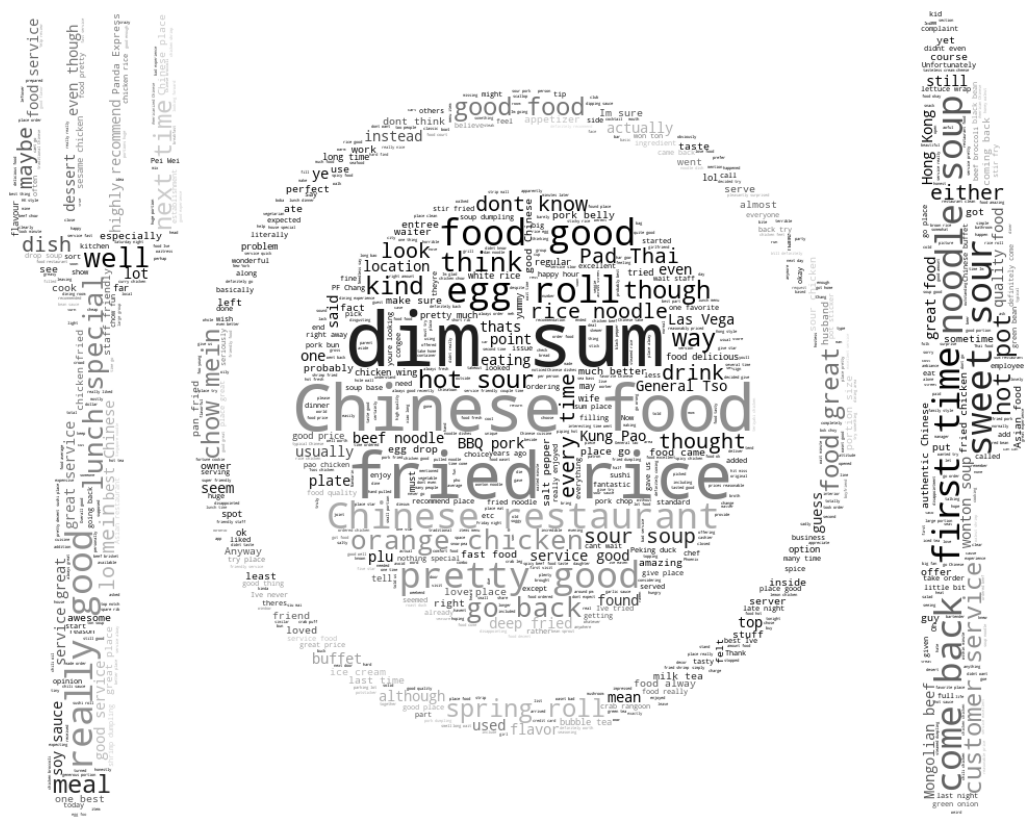

In [187]:
#creating wordcloud, top 1000 words
wordcloud = WordCloud(mask=mask, width=2000, height=1000,contour_color="black", max_words=1000,relative_scaling = 0, background_color = "white").generate(allText)
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,15])
plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")
_=plt.show()

In [72]:
wordcloud.to_file('Plot 1: ChineseRestaurantWordCloud.png')

## Part 3: New features (positive review rate for restaurant) to help user choose restaurant using Sentiment Analysis

### Part 3a: Clean Reviews and Review Sentiment Analysis

In [165]:
# A function that do sentiment analysis on each of the cleaned reviews
def sentiment(r):
    analysis = TextBlob(clean_review(r))
#     analysis = TextBlob(r)
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [166]:
review_chinese['sentiment'] = np.array([sentiment(review) for review in review_chinese['text']])

In [167]:
review_chinese[['text', 'useful', 'stars', 'sentiment']].head(2)

,text,useful,stars,sentiment
0,My girlfriend and I went for dinner at Emerald...,3,3.0,1
1,We've always been there on a Sunday so we were...,0,3.0,-1


In [168]:
print(review_chinese.groupby('sentiment')['review_id'].count().reset_index())

   sentiment  review_id
0         -1      41582
1          0       2480
2          1     217152


### Part 3b: Calculate the positive review ratio for Chinese restaurant 
positive review ratio = = positive reviews count / total review count for one Chinese restaurant

In [171]:
businessSenti = review_chinese.groupby(['business_id', 'sentiment'])['review_id'].count().reset_index()
businessSenti.columns = ['business_id', 'sentiment', 'reviewCount']
businessReviewCount = review_chinese.groupby(['business_id'])['review_id'].count().reset_index()
businessReviewCount.columns = ['business_id', 'reviewTotalCount']
ReviewRatio = pd.merge(businessSenti,businessReviewCount, how = 'left', left_on = 'business_id', right_on = 'business_id')

In [193]:
PositiveReviewRatio = ReviewRatio[ReviewRatio['sentiment'] == 1]
PositiveReviewRatio.loc[:,'PositiveReviewRate'] = PositiveReviewRatio.loc[:,'reviewCount']/PositiveReviewRatio.loc[:,'reviewTotalCount']

In [173]:
PositiveReviewRatio.head(2)

,business_id,sentiment,reviewCount,reviewTotalCount,PositiveReviewRate
1,--6MefnULPED_I942VcFNA,1,40,46,0.869565
3,--SrzpvFLwP_YFwB_Cetow,1,39,44,0.886364


Text(0.5, 0.98, 'Histogram of Positive Review Rate')

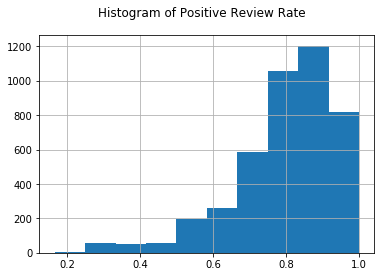

In [175]:
PositiveReviewRatio['PositiveReviewRate'].hist()
pl.suptitle('Histogram of Positive Review Rate')

Text(0.5, 0.98, 'Histogram of reviewTotalCount')

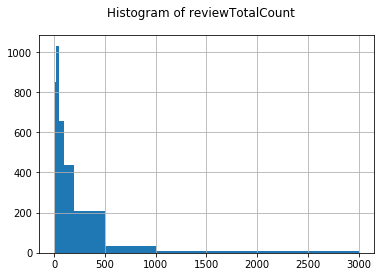

In [176]:
PositiveReviewRatio['reviewTotalCount'].hist(bins = [5,10, 20, 50, 100, 200, 500, 1000, 3000])
pl.suptitle('Histogram of reviewTotalCount')

### Part 3c: Explore the relationship between restaurant "stars" rating and positive review ratio

In [204]:
ReviewWithStars = pd.merge(PositiveReviewRatioFinal[['business_id', 'reviewTotalCount', 'PositiveReviewRate']], businessDF[['business_id', 'stars']], how = 'left', left_on = 'business_id', right_on = 'business_id')

# TO avoid the bias, I remove business that has less than ten reviews
ReviewWithStarsFilter = ReviewWithStars[ReviewWithStars['reviewTotalCount'] >=10]

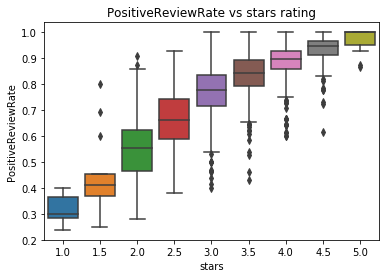

In [217]:
ax = sns.boxplot(x = 'stars', y = 'PositiveReviewRate', data = ReviewWithStarsFilter).set_title('PositiveReviewRate vs stars rating')

In [133]:
fig = ax.get_figure()
fig.savefig('Plot 2: Boxplot for positive review rate of each stars category.png')

### Part 4: Restaurant recommender system

I will use Item Collaborative Filtering algorithm. Reasons as listed:
1. The number of users weighs more than number of restaurants
2. restaurants will not change frequently, lowering calculation
3. Using user’s historical data, more convincing

I will use rating history from users to build relationship between restaurants. If one user rated two restaurants, these two are related.

In [169]:
review_chinese.head(2)
businessDF.head(2)

,Unnamed: 0,business_id,review_id,user_id,stars,useful,funny,cool,text,date,sentiment
0,0,QXAEGFB4oINsVuTFxEYKFQ,6W0MQHmasK0IsaoDo4bmkw,2K62MJ4CJ19L8Tp5pRfjfQ,3.0,3,2,0,My girlfriend and I went for dinner at Emerald...,2017-01-27 21:54:30,1
1,1,QXAEGFB4oINsVuTFxEYKFQ,BeeBfUxvzD4qNX4HxrgA5g,A0kENtCCoVT3m7T35zb2Vg,3.0,0,0,0,We've always been there on a Sunday so we were...,2013-06-24 23:11:30,-1


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours,attributes.GoodForKids,attributes.RestaurantsReservations,attributes.GoodForMeal,attributes.BusinessParking,attributes.Caters,attributes.NoiseLevel,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.RestaurantsPriceRange2,attributes.OutdoorSeating,attributes.BikeParking,attributes.Ambience,attributes.HasTV,attributes.WiFi,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsGoodForGroups,attributes.RestaurantsDelivery,hours.Monday,hours.Tuesday,hours.Wednesday,hours.Thursday,hours.Friday,hours.Saturday,hours.Sunday,attributes.BusinessAcceptsCreditCards,attributes,attributes.BusinessAcceptsBitcoin,attributes.ByAppointmentOnly,attributes.AcceptsInsurance,attributes.Music,attributes.GoodForDancing,attributes.CoatCheck,attributes.HappyHour,attributes.BestNights,attributes.WheelchairAccessible,attributes.DogsAllowed,attributes.BYOBCorkage,attributes.DriveThru,attributes.Smoking,attributes.AgesAllowed,attributes.HairSpecializesIn,attributes.Corkage,attributes.BYOB,attributes.DietaryRestrictions,attributes.Open24Hours,attributes.RestaurantsCounterService
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,"Golf, Active Life",NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"Specialty Food, Restaurants, Dim Sum, Imported...",NaN,True,True,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': False, 'validated'...",True,u'loud',True,True,2,False,False,"{'romantic': False, 'intimate': False, 'classy...",False,u'no',u'full_bar',u'casual',True,False,9:0-0:0,9:0-0:0,9:0-0:0,9:0-0:0,9:0-1:0,9:0-1:0,9:0-0:0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [170]:
len(review_chinese['business_id'].unique())
len(review_chinese['user_id'].unique())
len(review_chinese['review_id'].unique())
len(review_chinese['sentiment'].unique())
review_chinese.shape

4304

153268

261214

3

(261214, 11)

In [178]:
reviewFinal = pd.merge(review_chinese[['business_id', 'user_id', 'stars', 'sentiment']], businessDF[['business_id', 'name', 'review_count', 'city']], how = 'inner', left_on = 'business_id', right_on = 'business_id') #stars > 3
reviewFinal.shape

(261214, 7)

In [194]:
reviewFinal.head(2)

,business_id,user_id,stars,sentiment,name,review_count,city
0,QXAEGFB4oINsVuTFxEYKFQ,2K62MJ4CJ19L8Tp5pRfjfQ,3.0,1,Emerald Chinese Restaurant,128,Mississauga
1,QXAEGFB4oINsVuTFxEYKFQ,A0kENtCCoVT3m7T35zb2Vg,3.0,-1,Emerald Chinese Restaurant,128,Mississauga


### Part 4a: Recommender algorithm

In [18]:
def filter_res(reviewFinal, city, review_count):
    review_filter = reviewFinal[(reviewFinal['city'] == city) & (reviewFinal['review_count'] >= review_count)]
    return review_filter

In [19]:
def corr_matrix(reviewTable):
    corr_matrix = reviewTable.pivot_table(index='user_id', columns='business_id', values='stars')
    return corr_matrix

In [195]:
def get_Restaurant(reviewFinal, user_id, city, review_count):
    review_res = filter_res(reviewFinal, city, review_count)
    restaurants = review_res[(review_res['user_id'] == user_id) & review_res['sentiment'] == 1]['business_id'].unique().tolist()
    if restaurants == []:
        print('No enough information to recommend restaurants')

    corr_lst = pd.DataFrame({'Correlation' : []})
    for res in restaurants:
        resMatrix = corr_matrix(review_res)
        res_rating = resMatrix[res]
        similarity = resMatrix.corrwith(res_rating)
        corr = pd.DataFrame(similarity, columns=['Correlation'])
        corr_lst = corr_lst.append(corr)
    
    recommender_raw1 = corr_lst.reset_index()
    recommender_raw1.columns = ['business_id', 'Correlation']
    recommender_raw2 = recommender_raw1[~recommender_raw1['business_id'].isin([res])]
    recommender = recommender_raw2.sort_values(by='Correlation', ascending=False).head(15)
    final = pd.merge(recommender, reviewFinal[['business_id', 'name']], how = 'inner', left_on = 'business_id', right_on = 'business_id').drop_duplicates()
    return final[['business_id', 'name', 'Correlation']] 

### Part 4b: Recommender system: obtain recommended restaurant list for a given user

In [196]:
# recommended restaurant list for user '--6u02ZqjZRnwtX3t9bZtQ'
get_Restaurant(reviewFinal, '--6u02ZqjZRnwtX3t9bZtQ', 'Las Vegas', 10)

,business_id,name,Correlation
0,3TRgD3KLVis61eGvMZrykA,SK Seafood Restaurant 勝記,1.000000
153,U1XLS-uQJVnQRvshnvAeXQ,The Little Kitchen Cafe,1.000000
243,dVhGY-mNwTWQzK01Zxuclw,Yunnan Garden,1.000000
554,EvE23d1PSbfGWe7EA5HRBQ,The Magic Noodle,1.000000
987,JjjlhlQ2LEaQMuAug4fDIA,Yi Mei Champion Taiwan Deli,1.000000
1295,VKmGedwOk-16D7OawNg_ng,Buffet At Asia,1.000000
1721,x8O-Mll5ksDpeIgtA0XY-w,Buffet At Asia,1.000000
1983,966W5oXOBW0ZWhNYy0yjcA,Wendy's Noodle Cafe,1.000000
2570,EdY6q0CO2mlATpoTFkvHAw,Dim Sum Cafe,1.000000
2975,IBNWrN1k9E0E_bMcRD-GwA,Chef Ching's Kitchen,1.000000


In [198]:
get_Restaurant(reviewFinal, '--D8T8lqv2YnX8BebVQBdg', 'Las Vegas', 10) #-13_toWl3Cg6v-KQXHj9tw	

,business_id,name,Correlation
0,5OqrwhtZ3mcmUSwLINZTWQ,Blossom,1.000000
324,n0bg7kf6HcpFchCtxJyc5A,Mr Chow,1.000000
727,hDL3Q-GNQlOuE04_zWEMJA,Krazy Buffet,1.000000
1127,JdoBiBRgeS_KKaNaU1sofA,Dong Ting Spring,1.000000
1205,-FcZY7a7qgxTUlTvwuyJnQ,8 Noodle Bar,1.000000
1475,wOmtCPiB-xeU-HknjTW4hQ,China One,1.000000
1546,czyhvf93Txsfxdxqcm16mA,Rice n Noodle,1.000000
1964,UMWzaFhW6M3nsIDyIpMfhg,Little Dumpling,1.000000
1978,TrN8HBHBL4-Tu7cXMDoopQ,Golden Flower Chinese Cuisine,1.000000
2210,S5FTckOpSK0_Ma4c18ZEgg,Wo Fat,1.000000
